# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
1. pytorch // [инструкция по установке](https://pytorch.org/)
2. torchvision // pip install ...
3. matplotlib  //
4. PIL
5. scipy
6. numpy
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    # no B, single pic
    squeez_out = False
    if len(x.shape) == 3:
        squeez_out = True
        x = x.unsqueeze(0)
    B, C, H, W = x.shape
    padded_x = torch.zeros(B, C, H+padding[0]*2, W+padding[1]*2, dtype=torch.float)
    padded_x[:, :, padding[0]:padding[0]+H, padding[1]:padding[1]+W] = x
    
    out_dim = (int((H + 2*padding[0] - kernel.shape[1]) / stride[0] + 1),
               int((W + 2*padding[1] - kernel.shape[2]) / stride[1] + 1))
    out = torch.zeros(B, *out_dim, dtype=torch.float)
    kernel = kernel.unsqueeze(0)
    for i in range(out_dim[0]):
        for j in range(out_dim[1]):
            out[: ,i, j] = torch.sum(
                padded_x[:, :, i*stride[0] : i*stride[0] + kernel.shape[2], j*stride[1] : j*stride[1] + kernel.shape[3]] * 
                kernel,
                dtype=torch.float
            )
    if squeez_out:
        out = out.squeeze()
    if bias is not None:
        out += bias
    return out
# from my_conv2d import my_conv2d

In [2]:
# функции тестирования
from tests_functions import * 

### Загружаем картинку 

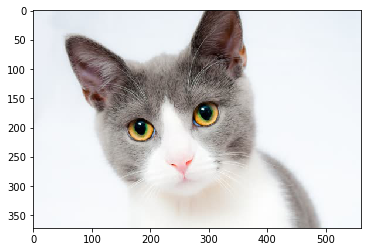

In [3]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [4]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [5]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])


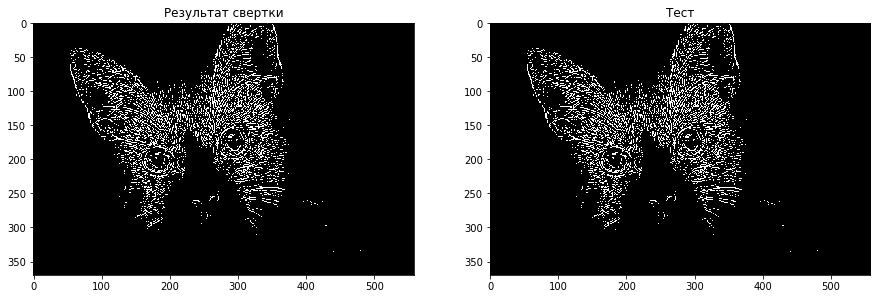

In [6]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [7]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


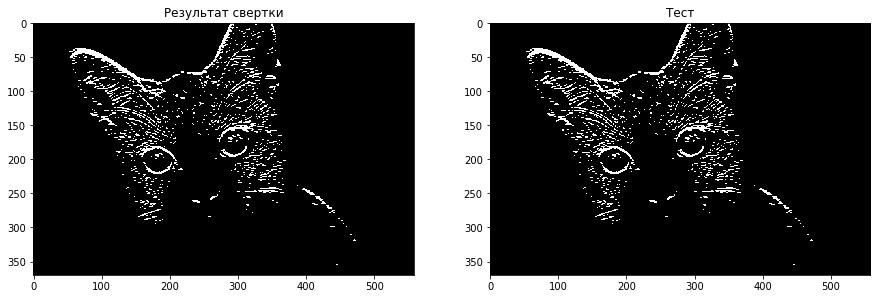

In [8]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [9]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


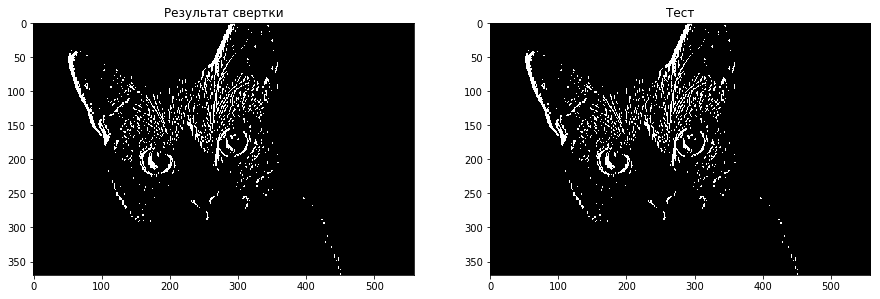

In [10]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
torch.Size([186, 280])


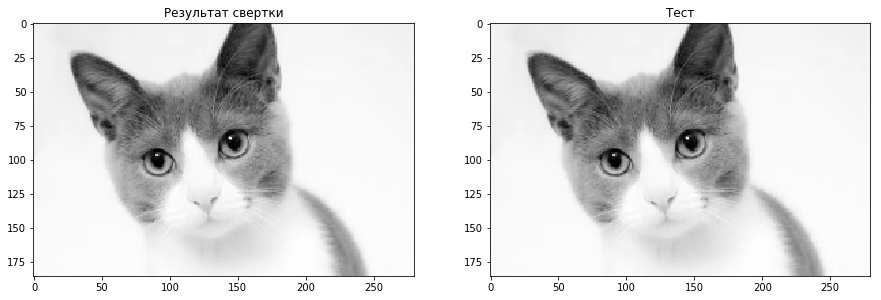

In [11]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

torch.Size([372, 560])


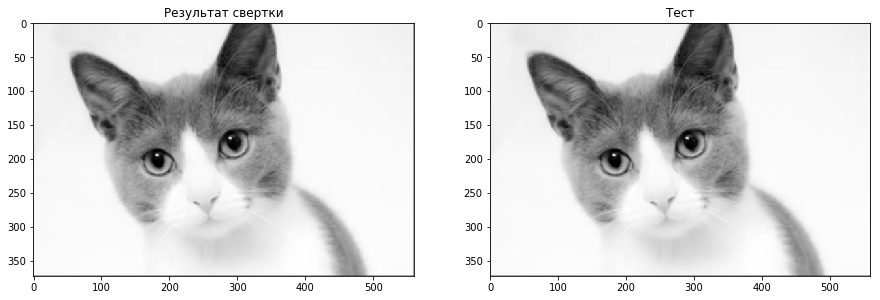

In [12]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

torch.Size([187, 281])


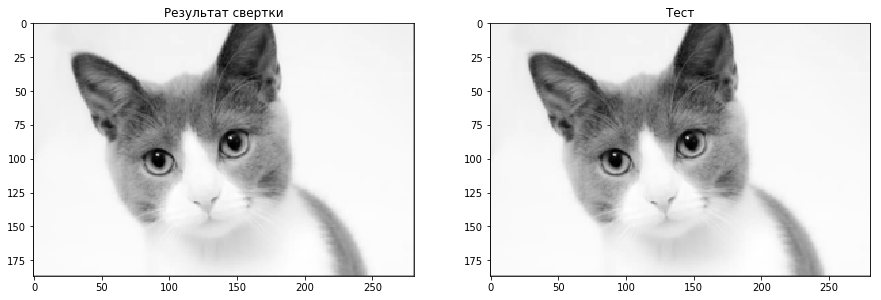

In [13]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

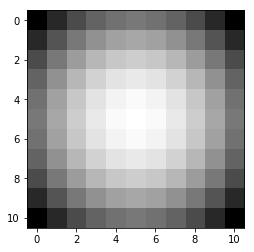

In [14]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


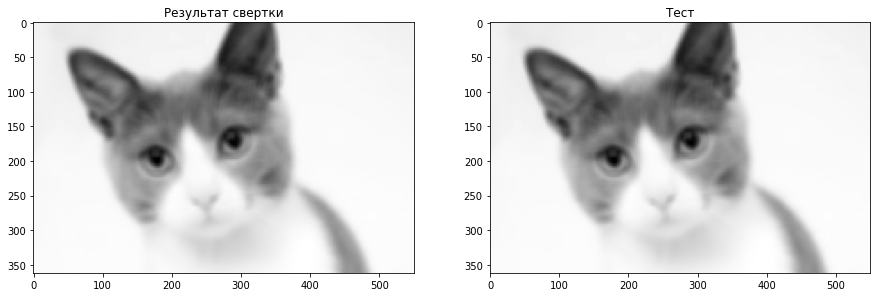

In [15]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторв)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

In [16]:
import torch.nn as nn

import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
         Инициализация BN
         Если задан флаг afine, то должны быть проинициализированны матрицы гамма и b
         для осуществления афинных преобразований в процессе тренировки и теста.
         Обучаемый параметры устанавливаем как тензора соответсвующей размерности и сохраняем 
         их 
         self.weight
         self.bias
         В данном ДЗ мы не обучаем эти параметры, лишь реализуем саму концепцию.
         
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование в процессе обучения.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        if afine:
            self.weight = nn.Parameter(torch.rand(in_channels, requires_grad=True))
            self.bias = nn.Parameter(torch.zeros(in_channels, requires_grad=True))
        self.running_mean = torch.zeros(in_channels)
        self.running_var = torch.ones(in_channels)
        self.afine = afine
        self.beta = beta
        self.epsilon = epsilon
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        используем для расчета праметры gamma и b КАК обучаемые, т.е. учитываем, 
        что эти параметры должны быть обучены в процессе тренировки. 
        """
        out = torch.zeros_like(x)
        if self.training:
            mu = x.permute(1, 0, 2, 3).contiguous().view(x.shape[1], -1).mean(dim=1)
            var = x.permute(1, 0, 2, 3).contiguous().view(x.shape[1], -1).var(dim=1)
            
            self.running_mean = self.beta * self.running_mean + (1 - self.beta) * mu
            self.running_var = self.beta * self.running_var + (1 - self.beta) * var
            
            out = ((x - mu.view(1, -1, 1, 1).expand_as(x)) / 
                   torch.sqrt(var.view(1, -1, 1, 1).expand_as(x) + self.epsilon))
        else:
            out = ((x - self.running_mean.view(1, -1, 1, 1).expand_as(x)) / 
                   torch.sqrt(self.running_var.view(1, -1, 1, 1).expand_as(x) + self.epsilon))
            
        if self.afine:
            out = (out * self.weight.view(1, -1, 1, 1).expand_as(x) +
                   self.bias.view(1, -1, 1, 1).expand_as(x))
            
        return out

### Проверяем работу батч нормадлизации на котэ

torch.Size([372, 560, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


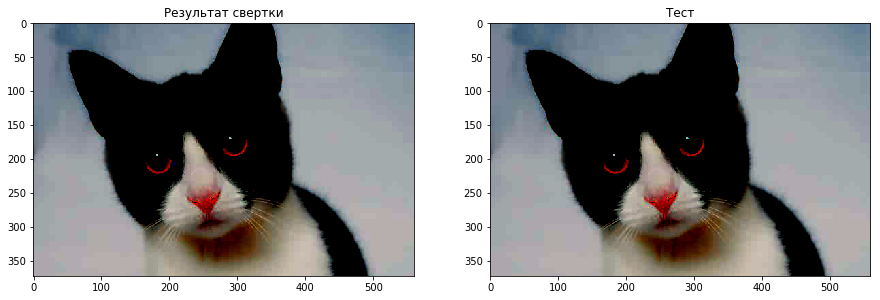

In [17]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_01.pth')

torch.Size([372, 560, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


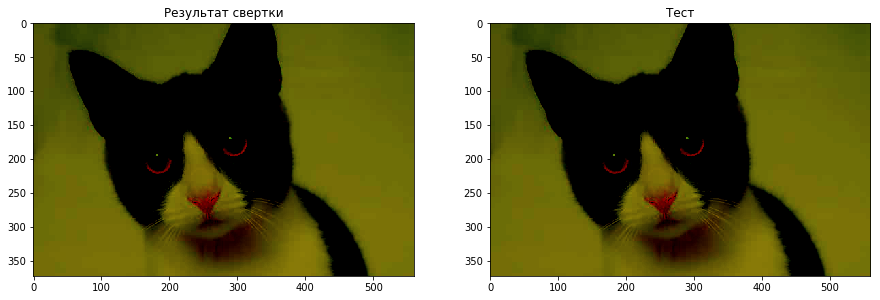

In [18]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image.detach(), './data/bn_02.pth')
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [19]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [20]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

C:\Users\tsanda.ap\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\tsanda.ap\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 1, 28, 28)


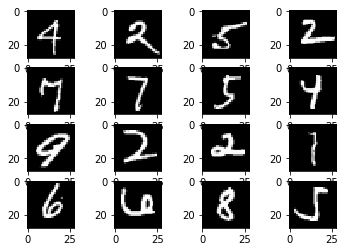

In [21]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [22]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.running_mean ] 
            var_curve +=  [ bn.running_var ]
    return mean_curve, var_curve

In [23]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


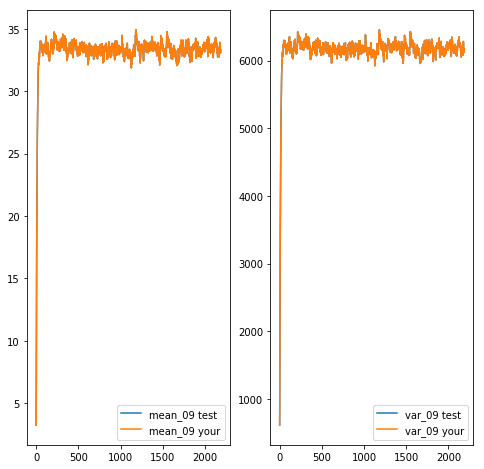

In [24]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


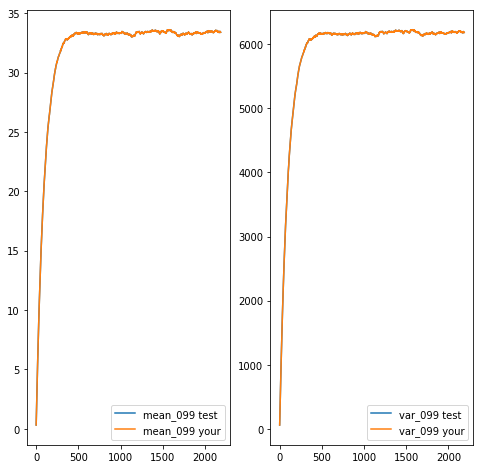

In [25]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


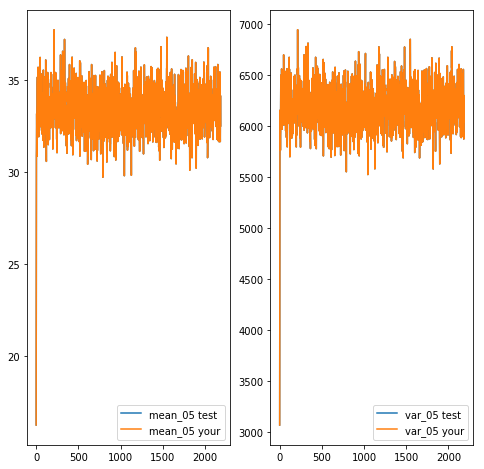

In [26]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [27]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.running_mean[0]) == 33
assert int(bn_099.running_mean[0]) == 33
assert int(bn_05.running_mean[0]) == 32
assert int(bn_09.running_var[0]) == 6136
assert int(bn_099.running_var[0]) == 6180
assert int(bn_05.running_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
ok


Посмотрим как повлияла батч нормализация на изображения

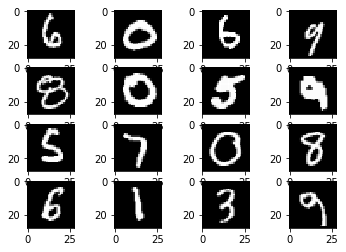

In [28]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тренировки
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]), 0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    assert (I == t_I).all(), "Что-то не так нормализованный тензор через running_mean и running_var не совпадают"
    plt.imshow(I.detach(), cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [29]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).add_(1 - beta2, grad**2)
                step_size = group['lr'] * math.sqrt(1 - beta2**state['step']) / (1 - beta1**state['step'])

                # обновляем веса в p.data, 
                p.data -= step_size * exp_avg / torch.sqrt(exp_avg_sq + eps)
                
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [30]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                state = self.state[p]
                if beta != 0:
                    if len(state) == 0:
                        state['exp_avg'] = torch.zeros_like(p.data)
                    exp_avg = state['exp_avg']
                    exp_avg.mul_(beta).add_(1 - beta, d_p)
                    d_p = exp_avg

                # обновляем веса
                p.data -= group['lr'] * d_p


        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [31]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [32]:
USE_CUDA=True

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [34]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss)
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [35]:
#net = Net(batchnorm=True)

In [36]:
#PATH = 'initial_net.pt'

In [37]:
#torch.save(net.state_dict(), PATH)

In [38]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.11916851695707033
Do epoch 1 with loss 0.05015523247778497
Do epoch 2 with loss 0.04006598195189693
Do epoch 3 with loss 0.033969744310893585
Do epoch 4 with loss 0.03040417886769657
Do epoch 5 with loss 0.027588289099901738
Do epoch 6 with loss 0.025351928650079167
Do epoch 7 with loss 0.02291146306057853
Do epoch 8 with loss 0.021035503890752028
Do epoch 9 with loss 0.019162222950846623
Do epoch 10 with loss 0.0187603221651785
Do epoch 11 with loss 0.01664574911360551
Do epoch 12 with loss 0.015169378606816324
Do epoch 13 with loss 0.014234393351308057
Do epoch 14 with loss 0.012493439073234483
Do epoch 15 with loss 0.011674124957030366
Do epoch 16 with loss 0.010867358207920669
Do epoch 17 with loss 0.010748824008425785
Do epoch 18 with loss 0.00927066478655117
Do epoch 19 with loss 0.00914187940918369


## SGD с моментом

In [39]:
learning_rate = 1e-1
net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.13537120029405203
Do epoch 1 with loss 0.054001564852412996
Do epoch 2 with loss 0.0421880035246814
Do epoch 3 with loss 0.03527344404376965
Do epoch 4 with loss 0.031282077147827665
Do epoch 5 with loss 0.026980316647122752
Do epoch 6 with loss 0.025468035902151735
Do epoch 7 with loss 0.022819318003342692
Do epoch 8 with loss 0.021568760320128617
Do epoch 9 with loss 0.01910617831407969
Do epoch 10 with loss 0.017145329763560084
Do epoch 11 with loss 0.015400203412452353
Do epoch 12 with loss 0.015046956434089624
Do epoch 13 with loss 0.013614575439492588
Do epoch 14 with loss 0.012394335231636014
Do epoch 15 with loss 0.011396797272539816
Do epoch 16 with loss 0.010584311996713096
Do epoch 17 with loss 0.009540579879207594
Do epoch 18 with loss 0.008335664098427401
Do epoch 19 with loss 0.00841626378775297


## Adam

In [40]:
learning_rate = 1e-3
net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.1765500799036075
Do epoch 1 with loss 0.05575970017274984
Do epoch 2 with loss 0.04346507671193331
Do epoch 3 with loss 0.03655545800363463
Do epoch 4 with loss 0.03225545310102332
Do epoch 5 with loss 0.028658267526636534
Do epoch 6 with loss 0.026438468396723282
Do epoch 7 with loss 0.02339196297142929
Do epoch 8 with loss 0.02196101263256179
Do epoch 9 with loss 0.01894880978509385
Do epoch 10 with loss 0.018795923914202067
Do epoch 11 with loss 0.016391171881512564
Do epoch 12 with loss 0.015718347325014117
Do epoch 13 with loss 0.01389764224168017
Do epoch 14 with loss 0.01268307743161818
Do epoch 15 with loss 0.012596405540345126
Do epoch 16 with loss 0.011429903932745306
Do epoch 17 with loss 0.011056730655185065
Do epoch 18 with loss 0.009188589947581356
Do epoch 19 with loss 0.009840694055367673


# Кривые обучения

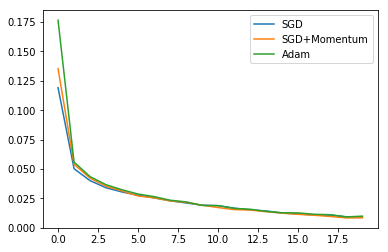

In [41]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

**Вывод**  
В поставленном эксперименте тяжело сделать какой-то общий вывод. После первой эпохи алгоритмы сходятся с одинаковой скоростью. До первой эпохи быстрее сходится SGD, потом SGD+Momentum, потом Adam. Я также поэксперементировал с начальным приближением, сохраняя инициализированные веса, чтобы начинать оптимизацию из одной точки, но это не дало эффекта. Библиотечные реализации ведут себя аналогично. Что я нашел для себя полезным, так это то, что leraning rate для адама необходимо брать на два порядка меньше.

In [42]:
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
res = {}

In [43]:
for lr in lrs:
    print('===========================================')
    print('lr = ', lr)
    net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
    net = net.cuda() if USE_CUDA else net
    optimizer = SGD(net.parameters(), lr=lr, beta=0.0)
    loss_curve_sgd = fit_net(20, net, optimizer)
    
    net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
    net = net.cuda() if USE_CUDA else net
    optimizer = SGD(net.parameters(), lr=lr, beta=0.9)
    loss_curve_sgd_momentum = fit_net(20, net, optimizer)
    
    net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
    net = net.cuda() if USE_CUDA else net
    optimizer = Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
    loss_curve_adam = fit_net(20, net, optimizer)
    
    res[lr] = {'sgd': loss_curve_sgd, 'sgd_momentum': loss_curve_sgd_momentum, 'adam': loss_curve_adam}

lr =  0.1
Do epoch 0 with loss 0.11832308902771004
Do epoch 1 with loss 0.050903611276920495
Do epoch 2 with loss 0.0405006604137135
Do epoch 3 with loss 0.034108848796895935
Do epoch 4 with loss 0.030201091255207393
Do epoch 5 with loss 0.02713914995712399
Do epoch 6 with loss 0.024364897672122725
Do epoch 7 with loss 0.022359058683355703
Do epoch 8 with loss 0.020775402899087157
Do epoch 9 with loss 0.018659207668405828
Do epoch 10 with loss 0.01630448631407411
Do epoch 11 with loss 0.01614780048658764
Do epoch 12 with loss 0.014496162162423406
Do epoch 13 with loss 0.013227479381611972
Do epoch 14 with loss 0.012205146597191576
Do epoch 15 with loss 0.011492461722410592
Do epoch 16 with loss 0.010571115195860207
Do epoch 17 with loss 0.01074026470853141
Do epoch 18 with loss 0.008989387541450644
Do epoch 19 with loss 0.008574187169622273
Do epoch 0 with loss 0.14004316450248694
Do epoch 1 with loss 0.05587471493191516
Do epoch 2 with loss 0.04424038512702941
Do epoch 3 with loss 0.0

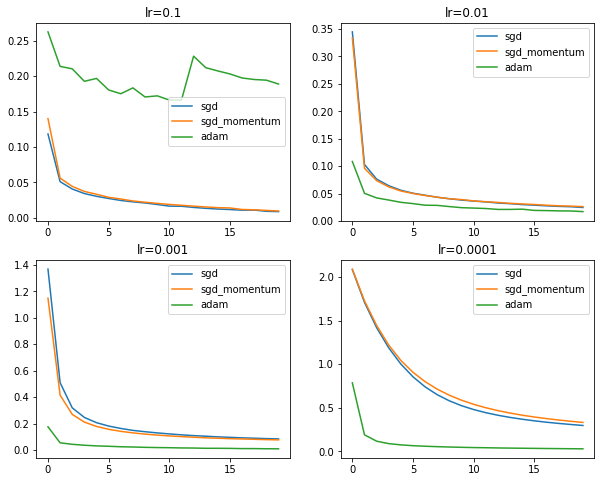

In [44]:
fig, axes = plt.subplots((len(res)+1) // 2, 2, figsize=(10, 8))

for lr, ax in zip(res.keys(), axes.reshape(-1)):
    ax.set_title(f'lr={lr}')
    for alg in res[lr]:
        ax.plot(res[lr][alg], label=f'{alg}')
    ax.legend()

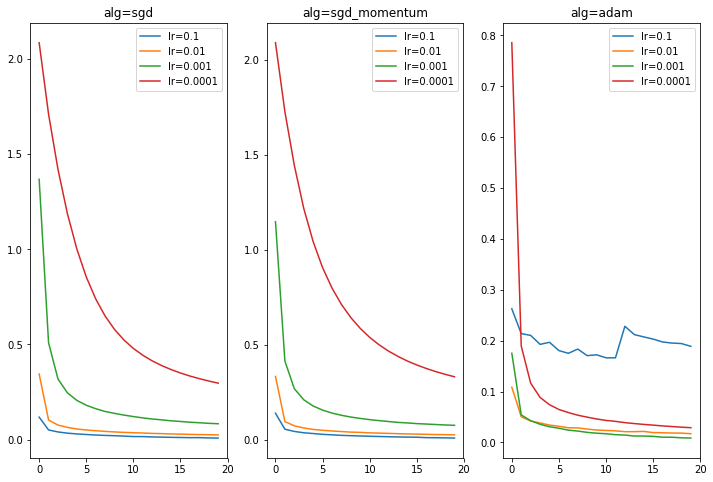

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12, 8))

for alg, ax in zip(res[list(res.keys())[0]].keys(), axes.reshape(-1)):
    ax.set_title(f'alg={alg}')
    for lr in res.keys():
        ax.plot(res[lr][alg], label=f'lr={lr}')
    ax.legend()

In [46]:
betas = [0.9, 0.99, 0.5]
momentum_res = {}

In [47]:
for beta in betas:
    learning_rate = 1e-1
    net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
    net = net.cuda() if USE_CUDA else net
    optimizer = SGD(net.parameters(), lr=learning_rate, beta=beta)
    loss_curve_sgd_momentum = fit_net(20, net, optimizer)
    momentum_res[beta] = loss_curve_sgd_momentum

Do epoch 0 with loss 0.13043913274839908
Do epoch 1 with loss 0.054518881284133125
Do epoch 2 with loss 0.04163377646188186
Do epoch 3 with loss 0.0354466687020887
Do epoch 4 with loss 0.03037222745650753
Do epoch 5 with loss 0.02735857462155312
Do epoch 6 with loss 0.024609525242133067
Do epoch 7 with loss 0.02236279591434232
Do epoch 8 with loss 0.02018100129901191
Do epoch 9 with loss 0.018900532457699883
Do epoch 10 with loss 0.016554055550652223
Do epoch 11 with loss 0.01679118140802898
Do epoch 12 with loss 0.01468547729321359
Do epoch 13 with loss 0.014058822926915722
Do epoch 14 with loss 0.01352637909288051
Do epoch 15 with loss 0.012371431765324131
Do epoch 16 with loss 0.010196470572461152
Do epoch 17 with loss 0.009571175346049643
Do epoch 18 with loss 0.009635464661760204
Do epoch 19 with loss 0.007758081613417679
Do epoch 0 with loss 0.21410574009416308
Do epoch 1 with loss 0.06020064071795141
Do epoch 2 with loss 0.048347364632463044
Do epoch 3 with loss 0.03986267465118

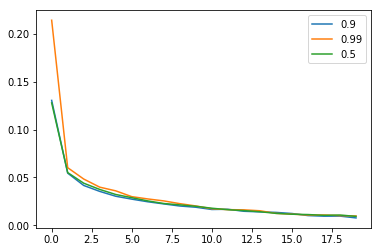

In [48]:
for b in momentum_res:
    plt.plot(momentum_res[b], label=b)
plt.legend()

In [49]:
from itertools import product
adam_res = {}

In [50]:
for betas in product([0.9, 0.99, 0.5], [0.9, 0.99, 0.5]):
    learning_rate = 1e-3
    net = Net(batchnorm=True)#net.load_state_dict(torch.load(PATH))
    net = net.cuda() if USE_CUDA else net
    optimizer = Adam(net.parameters(), lr=learning_rate, betas=betas)
    loss_curve_adam = fit_net(20, net, optimizer)
    adam_res[betas] = loss_curve_adam

Do epoch 0 with loss 0.1659859788175468
Do epoch 1 with loss 0.05652154450912487
Do epoch 2 with loss 0.045037752619044275
Do epoch 3 with loss 0.03889807931991327
Do epoch 4 with loss 0.03331409564397626
Do epoch 5 with loss 0.03055827932157198
Do epoch 6 with loss 0.027936484809465804
Do epoch 7 with loss 0.026253573518122065
Do epoch 8 with loss 0.023378771546228215
Do epoch 9 with loss 0.021430856522273188
Do epoch 10 with loss 0.02064566594255968
Do epoch 11 with loss 0.019285706580911645
Do epoch 12 with loss 0.01767698946912702
Do epoch 13 with loss 0.016924595486698054
Do epoch 14 with loss 0.015811641752093035
Do epoch 15 with loss 0.015445894229123186
Do epoch 16 with loss 0.01487101830463732
Do epoch 17 with loss 0.013631041757472857
Do epoch 18 with loss 0.012457091758171609
Do epoch 19 with loss 0.012072532047242075
Do epoch 0 with loss 0.1780296475147453
Do epoch 1 with loss 0.05037455728182175
Do epoch 2 with loss 0.0406910914288528
Do epoch 3 with loss 0.033646584517675

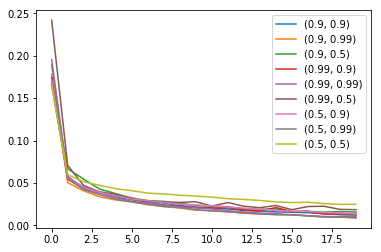

In [51]:
for b in adam_res:
    plt.plot(adam_res[b], label=b)
plt.legend()

In [52]:
import pandas as pd

In [53]:
pd.DataFrame.from_dict(adam_res).sum()

0.90  0.90    0.628138
      0.99    0.570528
      0.50    0.690383
0.99  0.90    0.640326
      0.99    0.622219
      0.50    0.793678
0.50  0.90    0.659161
      0.99    0.594533
      0.50    0.833179
dtype: float64

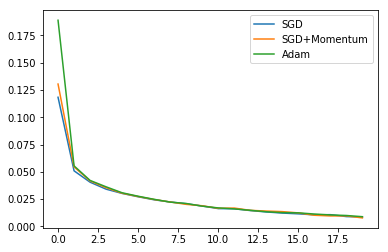

In [54]:
ax = plt.subplot(1,1,1)
ax.plot(res[0.1]['sgd'], label="SGD")
ax.plot(momentum_res[.9], label="SGD+Momentum")
ax.plot(adam_res[(.5, .99)], label='Adam' )
ax.legend()